In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import librosa
import pandas as pd

C:\Users\Abraham\anaconda3\envs\speech_rec\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [4]:
from pathlib import Path
audio_paths = []
labels = []
for label, name in enumerate(commands):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(commands))
)

Processing speaker down
Processing speaker go
Processing speaker left
Processing speaker no
Processing speaker right
Processing speaker stop
Processing speaker up
Processing speaker yes
Found 8000 files belonging to 8 classes.


In [ ]:
import librosa.feature
dataset = []
y = []
SAMPLE_RATE = 8000
for x,i in enumerate(audio_paths) :
    entry = []
    sample, SAMPLE_RATE = librosa.load(i,sr=SAMPLE_RATE)
    if(len(sample) == SAMPLE_RATE):
        dataset.append(sample)
        y.append(labels[x])

In [ ]:
print(len(dataset))
print(len(y))


In [78]:
y= tf.keras.utils.to_categorical(y, num_classes=len(commands))

In [79]:
y.shape

(7178, 8)

In [177]:
len(dataset[0])

8000

## Train Test Split

In [154]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(dataset).reshape(-1,8000,1),np.array(y),test_size=0.2,shuffle=True)

In [155]:
from tensorflow.keras.layers import Input,Dense,Flatten,Conv1D,MaxPooling1D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

## CNN Model

In [156]:
inputs=Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(commands), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8000, 1)]         0         
                                                                 
 conv1d_28 (Conv1D)          (None, 7988, 8)           112       
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 2662, 8)          0         
 g1D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 2662, 8)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 884, 16)          0         
 g1D)                                                      

### Compile Model

In [157]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rsmProp',metrics=['accuracy'])

In [158]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [159]:
history=model.fit(X_train, y_train ,epochs=50, callbacks=[es,mc], batch_size=64, validation_data=(X_test,y_test))

Epoch 1/50
90/90 [==============================] - 31s 335ms/step - loss: 2.0511 - accuracy: 0.1731 - val_loss: 2.0202 - val_accuracy: 0.1574
Epoch 2/50
90/90 [==============================] - 29s 325ms/step - loss: 1.8388 - accuracy: 0.2781 - val_loss: 1.6821 - val_accuracy: 0.3670
Epoch 3/50
90/90 [==============================] - 29s 322ms/step - loss: 1.5766 - accuracy: 0.3729 - val_loss: 1.5165 - val_accuracy: 0.4199
Epoch 4/50
90/90 [==============================] - 29s 321ms/step - loss: 1.4114 - accuracy: 0.4518 - val_loss: 1.3838 - val_accuracy: 0.4777
Epoch 5/50
90/90 [==============================] - 29s 321ms/step - loss: 1.3060 - accuracy: 0.5033 - val_loss: 1.3607 - val_accuracy: 0.4951
Epoch 6/50
90/90 [==============================] - 29s 318ms/step - loss: 1.1841 - accuracy: 0.5538 - val_loss: 1.2120 - val_accuracy: 0.5578
Epoch 7/50
90/90 [==============================] - 29s 325ms/step - loss: 1.1030 - accuracy: 0.5782 - val_loss: 1.0978 - val_accuracy: 0.5919

Epoch 28/50
90/90 [==============================] - 29s 325ms/step - loss: 0.3225 - accuracy: 0.8851 - val_loss: 0.5931 - val_accuracy: 0.8064
Epoch 29/50
90/90 [==============================] - 30s 329ms/step - loss: 0.3166 - accuracy: 0.8910 - val_loss: 0.7079 - val_accuracy: 0.7806
Epoch 30/50
90/90 [==============================] - 29s 327ms/step - loss: 0.3088 - accuracy: 0.8959 - val_loss: 0.6287 - val_accuracy: 0.8043
Epoch 31/50
90/90 [==============================] - 29s 327ms/step - loss: 0.2818 - accuracy: 0.9020 - val_loss: 0.7214 - val_accuracy: 0.8043
Epoch 32/50
90/90 [==============================] - 29s 322ms/step - loss: 0.2773 - accuracy: 0.9025 - val_loss: 0.7342 - val_accuracy: 0.7834
Epoch 33/50
90/90 [==============================] - 29s 325ms/step - loss: 0.2867 - accuracy: 0.9006 - val_loss: 0.6611 - val_accuracy: 0.8078
Epoch 34/50
90/90 [==============================] - 30s 329ms/step - loss: 0.2729 - accuracy: 0.9084 - val_loss: 0.7575 - val_accuracy:

## Plot Model Performance

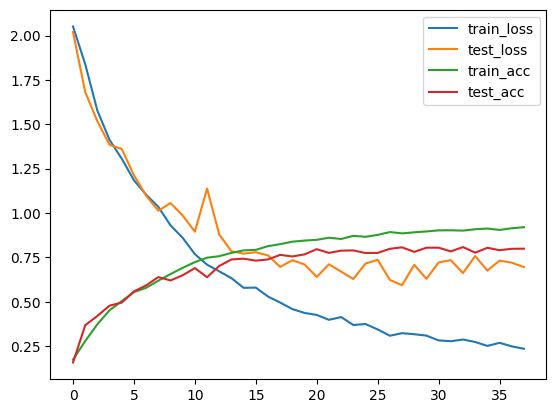

In [160]:
plt.plot(history.history['loss'], label='train_loss') 
plt.plot(history.history['val_loss'], label='test_loss') 
plt.plot(history.history['accuracy'], label='train_acc') 
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.legend() 
plt.show()

In [175]:
y,sr = librosa.load(audio_paths[9], sr=8000)
pred = np.argmax(model.predict([[np.array(y).reshape(-1,8000,1)]]))

1/1 [==============================] - 0s 27ms/step


In [176]:
pred

0

In [162]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=-1)

45/45 [==============================] - 2s 36ms/step


## Classification Report

In [163]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       173
           1       0.81      0.67      0.73       192
           2       0.82      0.68      0.74       186
           3       0.73      0.84      0.78       173
           4       0.93      0.89      0.91       157
           5       0.88      0.76      0.82       182
           6       0.74      0.86      0.79       177
           7       0.79      0.86      0.82       196

    accuracy                           0.80      1436
   macro avg       0.81      0.80      0.80      1436
weighted avg       0.80      0.80      0.80      1436



## Save Model

In [164]:
#model.save('my_model.h5')